# MLP vs CNN (bonus)

In lab 3 we have defined an MLP classifier, and in the previous script we used a CNN classifier. A natural question is: how do they compare, and which one is the best? The goal of this exercise is to answer this question, in terms of number of parameters, training behavior, and accuracy on the test set.

&nbsp; 

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*1Cw9nKcdKV5YQun-e4F8gQ.png"></a></center>

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy

# Define the data repository
data_dir = 'data/'

In [2]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

In [3]:
# Load the Fashion MNIST dataset
train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# TO DO: write the MLP and CNN (with batch norm) classifiers modules (you can reuse your code for the past scripts)

# MLP classifier
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super().__init__()
        
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        
        return out

# CNN classifier
class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super().__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2))
        
        self.lin_layer = nn.Linear(7*7*num_channels2, num_classes)
        
    def forward(self, x):
        
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        
        return out

In [5]:
# TO DO: write the training function.
# No need to write 2 functions (one for MLP and one for CNN), you can use the same but be careful about image vectorization.

# Training function
def training_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, is_mlp=True, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    
    # define the optimizer (SGD)
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to save the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # vectorize images (MLP only)
            if is_mlp:
                images = images.reshape(images.shape[0], -1)
            
            # forward pass
            y_predicted = model_tr(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            tr_loss += loss.item() * images.shape[0]

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
        
    return model_tr, train_losses

In [6]:
# TO DO: write the evaluation function (again, no need to write 2)

def eval_classifier(model, eval_dataloader, is_mlp=True, verbose=True):

    # Set the model in eval mode
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            if is_mlp:
                images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [7]:
# Common parameters
num_classes = 10
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

# MLP
input_size_mlp = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size_mlp = 50
act_fn_mlp = nn.Sigmoid()

# CNN
num_channels1 = 16
num_channels2 = 32

In [8]:
# TO DO: Instanciate, initialize and train the two models. Compute accuracy on the test set
model_mlp = MLPClassif(input_size_mlp, hidden_size_mlp, num_classes, act_fn_mlp)
torch.manual_seed(0)
model_mlp.apply(init_weights)
model_mlp, train_losses_mlp = training_classifier(model_mlp, train_dataloader, num_epochs, loss_fn, learning_rate, is_mlp=True, verbose=False)
accuracy_mlp = eval_classifier(model_mlp, test_dataloader, is_mlp=True, verbose=True)

model_cnn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)
torch.manual_seed(0)
model_cnn.apply(init_weights)
model_cnn, train_losses_cnn = training_classifier(model_cnn, train_dataloader, num_epochs, loss_fn, learning_rate, is_mlp=False, verbose=False)
accuracy_cnn = eval_classifier(model_cnn, test_dataloader, is_mlp=False, verbose=True)

Total number of parameters:
  MLP: 42310
  CNN: 29034


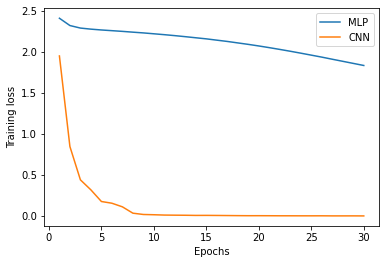

Test accuracy:
   MLP :  46.0 %
   CNN :  72.0 %


In [9]:
# TO DO: compare the MLP and CNN models
# - print the number of parameters of each model
# - plot the training loss
# - display the test accuracy

print('Total number of parameters:')
print('  MLP:', sum(p.numel() for p in model_mlp.parameters()))
print('  CNN:', sum(p.numel() for p in model_cnn.parameters()))

plt.figure()
plt.plot(np.arange(1, num_epochs+1), train_losses_mlp, label='MLP')
plt.plot(np.arange(1, num_epochs+1), train_losses_cnn, label='CNN')
plt.xlabel('Epochs'), plt.ylabel('Training loss')
plt.legend()
plt.show()

print('Test accuracy:')
print('   MLP : ', accuracy_mlp, '%')
print('   CNN : ', accuracy_cnn, '%')

<span style="color:red">**Q5**</span> Put these results in your report. Which network would you recommend?